<img src='https://blue-cloud.org/sites/default/files/styles/news_responsive/public/Blue-Cloud%20Banner%204%20Website%20%281%29.png?itok=516yZbuz' align='right' width='25%'/>

**Author:**  Giovanni Paolini<br>
**Copyright:** 2022 Giovanni Paolini <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1>GORNER GLACIER STUDY</h1></div>

## NOTEBOOK INTRODUCTION

### Data used (example - you can change this to suit your data sets)

| Product Description | Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Copernicus High Resolution Snow and Ice Monitoring: Persistent Snow Area | <a href="https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-snow-and-ice-monitoring/snow-products/persistent-snow-area" target="_blank">link</a> | EO:CRYO:DAT:HRSI:PSA | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3ACRYO%3ADAT%3AHRSI%3APSA" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know:
* How the Persistent Snow Area (PSA) product is derived from Sentinel-2 data and what are its characteristic.
* How to retrieve PSA data from the WEkEO DIAS service.
* How to extract useful data in the region of interest and visualize changes it.
* How to analyse PSA and create a qualitative & quantitative assessment of PSA change.

### Introduction

Glaciers around the world have lost well over 9000 gigatonnes (nine trillion tonnes) of ice since 1961, raising sea level by 27 mm **[1]**.

The Swiss Gorner glacier, one of the biggest ice masses in the Alps on the west side of the monte Rosa, is intensively monitored because of the very evident accelerated ice loss caused by climate change. During the summer of 2021, an international scientific expedition was organized to better study the Gorner glacier in preparation for the COP26 conference (Glasgow, 2021). The expedition was joined by ESA Astronaut Luca Parmitano along with Susanne Mecklenburg, Head of ESA’s Climate Office **[2]** which contributed to bring back the pubblic attention on this issue.

*Figure 1* shows an analysis extrapolated from historical data on the area covered by the glacier in 1850 and 1973, compared with the more recent situation in 2010 and the Copernicus satelllite image from 2020. Below, *Figure 2* shows a stunning visual comparison of the glaciar extension between an historical image from 1926 and a picture taken in 2021 **[3]**.

<figure>
<img align="left" src=https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2021/08/historic_outline_of_the_gorner_glacier_and_surrounding_area/23434550-2-eng-GB/Historic_outline_of_the_Gorner_Glacier_and_surrounding_area.jpg width="100%">
<figcaption align = "center"><b>Fig. 1. Credit: Copernicus Sentinel data (2020) and Historical glacier data from Glacier Monitoring in Switzerland (GLAMOS).</b></figcaption>
</figure>
<figure>
<img align="left" src=https://onthetrailoftheglaciers.com/wp-content/uploads/2019/03/S002047711_13-001-1.jpg width="1000">
<figcaption align = "center"><b>Fig. 2. Historical comparison of the Gorner glacier, 1926 (left) to 2021 (right) Credit: https://onthetrailoftheglaciers.com/.
</b></figcaption>
</figure>

### Notebook description

This notebook will present an application to retrieve glacier outline and calculate glacier's areas using the **Persistent Snow Area (PSA)** annual product derived from Sentinel-2 data **[4]** and distributed by the WEkEO DIAS service **[5]**. Data are produced from an aggregation of all the Fractional Snow Cover (FSC) maps, where pixels are classified as persistent snow area when snow is observed in at least for 95% of the observations (under clear sky conditions).

Thanks to the PSA satellite product, it is possible to study the surfece loss of snow area of the Gorner glacier over the last year, giving updated information on the status of the glacier.



<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Section 1](#section1) Using the WEkEO API to extract the maps of PSA from 2017 to 2021 for the area sourrounding the Gorner Glacier.
 2. [Section 2](#section2) Merge (for each year) all the tiles downloaded and extract the region of interest.
 3. [Section 3](#section3) Assess of the quality of PSA data using the Quality Control (QC) layer which is provided with each map.
 4. [Section 4](#section4) Creating 2 qualitative visualizations of PSA decrease throughout the years.
 5. [Section 5](#section5) Performing a quantitative estimation of Persistent Snow Area inside the region of interest and estimating the rate of ice loss for the past 5 years.

<hr>

### References

**[1]** Zemp, M., Huss, M., Thibert, E. et al. Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature 568, 382–386 (2019).

**[2]** https://www.esa.int/Applications/Observing_the_Earth/Space_for_our_climate/ESA_astronaut_joins_glacier_expedition_in_Alps

**[3]** https://onthetrailoftheglaciers.com/

**[4]** https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-snow-and-ice-monitoring/snow-products/persistent-snow-area

**[5]** https://www.wekeo.eu/data


In [1]:
# library imports 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from hda import Client, Configuration
from pathlib import Path
import getpass
import zipfile
import filetype
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats
from tqdm import tqdm
# packages for raster processing and visualization
import rasterio as rio
from rasterio.plot import show as rioshow
from rasterio.mask import mask as riomask
from rasterio.merge import merge as riomerge
from rasterio.features import shapes as rioshapes
from shapely.geometry import shape, box
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as ipywd
import ipyleaflet as ipylf
from ipyleaflet import Map, Marker, GeoData, basemaps
%matplotlib widget

In [3]:
# Useful functions used throughout the notebook
def check_if_zip_and_download(filezipped, outfold_unzip, delete_zip = False):
    fileout = outfold_unzip / filezipped.name.replace('.zip','')
    if fileout.exists():
        print(f"{fileout.name} already unzipped")
        return fileout
    
    kind = filetype.guess(filezipped)
    compressed_types = ['zip']#,'gz','tar', 'rar']
    if kind is None:
        print('Cannot guess file type!')
    elif kind.extension in compressed_types:    
        if not fileout.exists:
            print(fileout)
            print('File extension: %s' % kind.extension)
            print('File MIME type: %s' % kind.mime)
            with zipfile.ZipFile(filezipped, 'r') as zip_ref:
                zip_ref.extractall(outfold_unzip)
                print('files unzipped!')
        if delete_zip: #delete the original file
            Path(filezipped).unlink()
        return fileout
    
def check_existence_and_download_files(matches, outfold_zip = None, outfold_unzip = None):
    """
    Check if the files are already downloaded in the folder 'outfold_zip', otherwise download them and unzip them into
    'outfold_unzip' if needed. If not specified, both folders are the same as the working directory.
    INPUTS:
        - matches: hda.api.SearchResults object
                   collection of all the matches found in the weekeo database.
        - outfold_zip: str or pathlib.Path, default None
                         Folder where to save directly donloaded files (if not specified is taken as the current directory)
        - outfold_unzip: str or pathlib.Path, default None
                           Folder where to save unzipped files (if not specified is taken as the current directory)
    """
    all_files = []
    
    if outfold_zip is None:
        outfold_zip = Path.cwd()
    else:
        outfold_zip = Path(outfold_zip)
    outfold_zip.mkdir(exist_ok = True) #create directory if it does not exists
    if outfold_unzip is None:
        outfold_unzip = Path.cwd()
    else:
        outfold_unzip = Path(outfold_unzip)
    outfold_unzip.mkdir(exist_ok = True) #create directory if it does not exists
            
    for match in tqdm(matches, desc = 'downloading and unzipping'):
        zipped_file_path   = outfold_zip / match.results[0].get("filename")
        unzipped_file_path = outfold_unzip / match.results[0].get("filename").replace('.zip','')
        if (not zipped_file_path.exists()) and (not unzipped_file_path.exists()):
            match.download(download_dir=outfold_zip)
        unzipped_file_path = check_if_zip_and_download(zipped_file_path, outfold_unzip, delete_zip = True)
        all_files.append(unzipped_file_path)
    return all_files

def create_image_with_legend(ax, array, transform, colors, values, labels, dict_legend = {}):
    """Create a 2D image of an array with a legend with corresponding colors.
    INPUTS:
        - ax: matplotlib.pyplot.axes
            axes where to draw the image.
        - array: numpy.ndarray
                2D array with values of the image.
        - transfom: Affine
            Affine containing data for transformation of teh array into the reference frame.
        - colors: list
            List of strings containing color types.
        - values: list
            List of int or float (same length as colors) that rapresent the values in the array to be colored as colors.
        - labels: list
            List of strings (same length as colors) that rapresent the labels in the legend.
        - dict_legend: dict
            any additional commands transmitted to the matplotlib.pyplot.legend.
        """
    n=0.1
    val2 = np.concatenate([[values[0]-n], np.array(values)+n])
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(val2, cmap.N)
    ax = rioshow(array, transform=transform, norm=norm, cmap = cmap, ax=ax, interpolation='nearest')
    patches_legend = [mpatches.Patch(facecolor=col,
                                     edgecolor='k',
                                     label=labels[val]) for col, val in zip(colors, values)]
    ax.legend(handles=patches_legend,**dict_legend)
    return ax

<div class="alert alert-info" role="alert">

## <a id='section1'></a> Section 1 - Connect to WEkEO API and retreive the PSA data for all the years for our region of interest
[Back to top](#TOC_TOP)

</div>

Data are downloaded in multiple tiles corresponding to the Sentinel-2 original 100km x 100 km

#### GET CONFIGURATION

Query for the WEkEo website

"boundingBoxValues" : Limits used to specify the region of interest (west, south, east, north).

"dateRangeSelectValues": The data range goes from 2017 (year of teh first available map) to 2022.

In [4]:
bounding_box_values = [7.7,45.8,7.92,46.0]

Persistent_snow_cover_request = {
  "datasetId": "EO:CRYO:DAT:HRSI:PSA",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": bounding_box_values
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "Observed",
      "start": "2017-01-01T00:00:00.000Z",
      "end": "2022-12-31T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "productType",
      "value": "PSA_WGS84"
    }
  ]
}

In the next cell the user will be asked to input the credentials for the WEkEO website

(this method is preferred here since it is esier than creating the configuration file, and it should be safe since the password is not visible at any time)

In [5]:
user = input('username:')
p = getpass.getpass(prompt = 'password:')

username:giovpao
password:········


DOWNLOAD DATA

In [6]:
config = Configuration(user=user,password=p)
c = Client(config=config)
print('Connection to API successful! now searching in the database...')
matches = c.search(Persistent_snow_cover_request)
print(matches)
# define folders where to stored downloaded and unzipped data
download_data_folder = Path().absolute() / 'DATA' / 'DOWNLOADED'
unzipped_data_folder = Path().absolute() / 'DATA' / 'UNZIPPED'
download_data_folder.mkdir(exist_ok = True, parents = True)
unzipped_data_folder.mkdir(exist_ok = True, parents = True)

Connection to API successful! now searching in the database...
SearchResults[items=20,volume=47.4M,jobId=IzJZ-dWT8jBTCgKQ2WTUXPhBpgw]


In [7]:
# download and unzip
all_files = check_existence_and_download_files(matches, 
                                               outfold_zip = download_data_folder,
                                               outfold_unzip = unzipped_data_folder)

downloading and unzipping: 100%|█████████████████████████████████████| 20/20 [00:00<00:00, 22944.77it/s]

PSA_20210509-142_S2_T32TLS_V101 already unzipped
PSA_20210509-142_S2_T32TMS_V101 already unzipped
PSA_20210506-145_S2_T32TLR_V101 already unzipped
PSA_20210506-145_S2_T32TMR_V101 already unzipped
PSA_20200501-150_S2_T32TMR_V100 already unzipped
PSA_20200501-150_S2_T32TMS_V100 already unzipped
PSA_20200501-150_S2_T32TLR_V100 already unzipped
PSA_20200501-150_S2_T32TLS_V100 already unzipped
PSA_20190507-145_S2_T32TMR_V100 already unzipped
PSA_20190502-150_S2_T32TLR_V100 already unzipped
PSA_20190502-151_S2_T32TLS_V100 already unzipped
PSA_20190502-150_S2_T32TMS_V100 already unzipped
PSA_20180505-147_S2_T32TLR_V100 already unzipped
PSA_20180505-147_S2_T32TMR_V100 already unzipped
PSA_20180505-147_S2_T32TMS_V100 already unzipped
PSA_20180505-148_S2_T32TLS_V100 already unzipped
PSA_20170517-133_S2_T32TMR_V100 already unzipped
PSA_20170510-142_S2_T32TLR_V100 already unzipped
PSA_20170510-142_S2_T32TMS_V100 already unzipped
PSA_20170507-145_S2_T32TLS_V100 already unzipped


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Section 2 - PROCESS THE DATA

For each year we will merge all the tiles together and extract only the data in the region of interest 

[Back to top](#TOC_TOP)

</div>

Here we set our Region of interest, which is specified in Lat/Lon, and then convert it into a local reference frame in meter

In [8]:
# BoundingBox of the area of interest but expressed in coordinate reference system (crs) = 'EPSG:4326' [deg]
original_bounding_box = [7.74340411, 45.91168158,  7.852408  , 46.00162252] 
crs_latlong = 'EPSG:4326'
crs_fig = 'EPSG:32632'
# CONVERSION: BoundingBox of the area of interest but expressed in crs = 'EPSG:32632' [m]
bounding_box = gpd.GeoSeries([box(*original_bounding_box)], crs = crs_latlong).to_crs(crs_fig)[0].bounds

years = [2017,2018,2019,2020,2021] #List of the years considered

In [9]:
all_years_data    = {k:[] for k in years}
for it, year in enumerate(years):
    psafiles = []
    qcfiles = []
    for fold in [f for f in all_files if f'PSA_{year}' in f.name]: # get all tiles from the same years
        tifffiles = list(fold.glob('*'))
        psafiles.extend([f for f in tifffiles if '_PSA.tif' in f.name])
        qcfiles.extend([f for f in tifffiles if '_QC.tif'  in f.name])
    
    # merge all tiles from same years together and extract only data inside the selected BoundingBox
    print(f'merging and extracting all data for year {year}')
    outarray, outtransform = riomerge(psafiles, bounds = bounding_box)
    outarrayqc, outtransformqc = riomerge(qcfiles, bounds = bounding_box)
    
    if it ==0: # save all the qc rasters in an array with 3 dimensions = [years, length, width]
        all_qc = np.empty((len(years), outarrayqc.shape[1], outarrayqc.shape[2]), dtype = int)
    all_qc[it,:,:] = outarrayqc
        
    all_years_data[year] = outarray[0,:,:] # save the PSA rasters in a dictionary with the different years as keys.

merging and extracting all data for year 2017
merging and extracting all data for year 2018
merging and extracting all data for year 2019
merging and extracting all data for year 2020
merging and extracting all data for year 2021


<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Section 3 - ANALYZE THE QUALITY CONTROL (QC) LAYER
    
The QC values goes from 0 (high quality) to 3 (minimal quality). 

[Back to top](#TOC_TOP)

</div>

Extracting the max values from all the years gives an aggregated QC map with the worst case scenario. 

Pixels where this aggregated qc value is too high (qc_max >= 3) cannot be considered, since it means that at least for one year the quality was minimal.

In [10]:
level_to_mask = 3 # level where the quality of the maps is minimal. 
qctot = all_qc.max(axis=0) # calculate maximum for each pixels over all the years (to extract the worst quality across the years)

Plot the QC aggregated map for visual inspection

Number of pixels with minimal quality (QC=3): 0


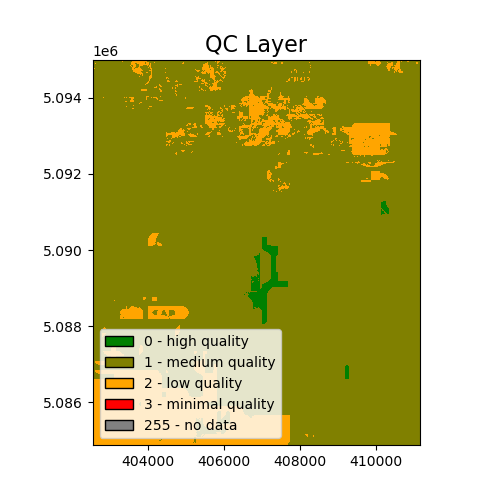

In [11]:
fig, ax_qc = plt.subplots(figsize = (5,5))
colors_qc = ['green', 'olive', 'orange', 'red', 'grey'] # CHOOSE COLORS of the map
bounds_qc = [0, 1, 2, 3, 255] # map values
labels_qc ={0: '0 - high quality',1: '1 - medium quality',2: '2 - low quality',3: '3 - minimal quality',255: '255 - no data'}
ax_qc = create_image_with_legend(ax_qc, array = qctot, transform = outtransformqc,
                                 colors =colors_qc, values=bounds_qc, labels=labels_qc, dict_legend=dict(loc = 'lower left'))
ax_qc.set_title('QC Layer', fontsize = 16)
print(f'Number of pixels with minimal quality (QC=3): {(qctot>=level_to_mask).sum()}')

Due to the bands we have selected, and the fact that this is a level-1 product, the image above is quite difficult to interpret. However with some understanding of the synoptic scale and typical patterns of different ocean and atmosphere features, we can see that the TIR bands can reveal variability associated with sea and land surfaces, and clouds/the atmosphere. This is the fundamental basis of how we can use this data for a diverse range of applications.

<div class="alert alert-danger" role="alert">

## <a id='section4'></a>Section 4. VISUALIZATION OF PSA CHANGE 
[Back to top](#TOC_TOP)

</div>

### Two different visualizations:
#### A. Overlap the raster to visually asses the change

interactive(children=(IntSlider(value=2017, description='(Move the slider to interact) YEAR:', layout=Layout(w…

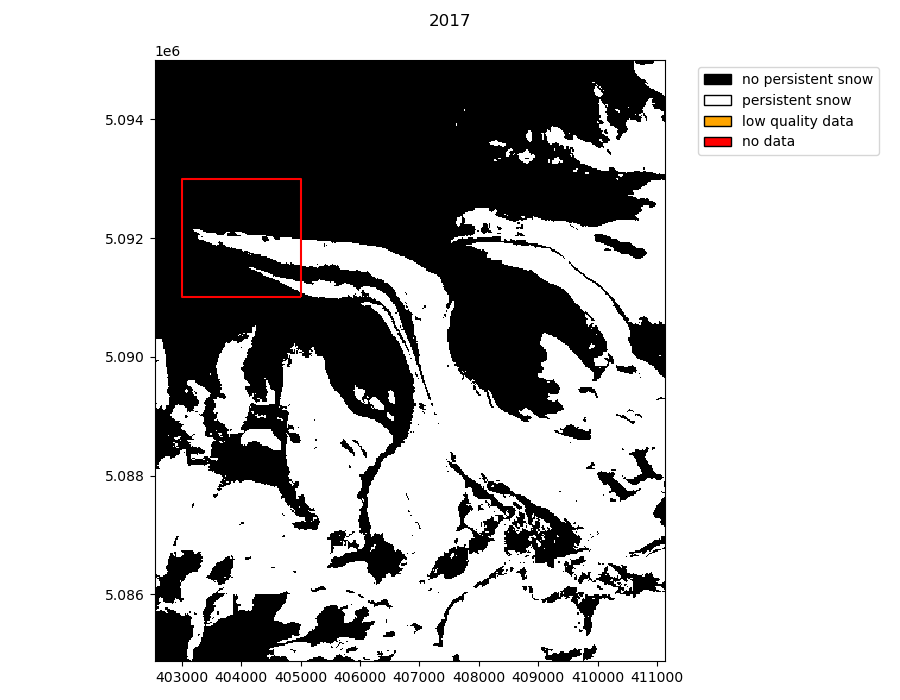

In [12]:
labels = {0: 'no persistent snow', 1: 'persistent snow', 253: 'low quality data', 255: 'no data'}
colors = ['black', 'white','orange','red']
bounds = [0,1,253,255]

starting_year = 2017

slider = ipywd.IntSlider(description='(Move the slider to interact) YEAR:', 
                         value = starting_year, min = 2017, max = 2021, step = 1,
                         style = {'description_width': 'initial'},
                         layout = ipywd.Layout(width = '50%'))

snow_data = all_years_data[starting_year].copy()
snow_data[qctot>=level_to_mask ]=253 #filter out low quality data
fig, ax = plt.subplots(tight_layout = True, figsize = (9,7))
ax      = create_image_with_legend(ax, array = snow_data, transform = outtransform,
                                   colors =colors, values=bounds, labels=labels, 
                                   dict_legend=dict(bbox_to_anchor=(1.05, 1), loc=2))
fig.suptitle(starting_year)
im = list(ax.get_images())[0]
@ipywd.interact(year = slider)
def update_maps(year):
    data = all_years_data[year].copy()
    data[qctot>=level_to_mask]=253 #filter out low quality data
    im.set_data(data)
    fig.suptitle(year)
    fig.canvas.draw()
    
# plot a red box to particularly focus on the Gorner glacier and the change on the glacier tongue
red_box_to_focus = gpd.GeoDataFrame(geometry = [box(403000,5091000, 405000,5093000)],
                                    crs = crs_fig).boundary.plot(ax=ax, color = 'r')

#### B. Plot all the glaciers contours in a single map, to directly compare the area loss.

Extract Contour of the Glacier

 - **Apply QC mask to raster:** now we can apply the mask to the PSA map to ignore pixels with low quality. 
 - **Polygonize the raster:** after applying the mask we can then extract the **outline** of the glaciers for each year.

In [13]:
all_shapes_data = {k:[] for k in years}
for year, outarray in all_years_data.items():
    single_array = outarray
    single_array[qctot>=level_to_mask] = 255
    single_array[single_array>1]=0
    shapes = []
    for sh in rioshapes(single_array, mask = outarray, transform=outtransform):
        shapes.append(shape(sh[0]))
    all_shapes = gpd.GeoDataFrame([year]*len(shapes), columns = ['name_shp'], geometry = shapes, crs = crs_fig)
    all_shapes_data[year] = all_shapes # save all the shapes in a dictionary with years as keys

Visualize the **ouline** of the glaciers into a map

In [14]:
# CREATE MAP
center = (45.97,7.77)
m = Map(basemap=basemaps.OpenStreetMap.HOT, center=center, zoom=14, scroll_wheel_zoom=True)
col = {2017:'green',
       2018:'blue',
       2019:'cyan',
       2020:'orange',
       2021:'yellow'
      }

# ADD SHAPES
layers = {year:[] for year in years}
for year in years:
    geom  = GeoData(geo_dataframe = all_shapes_data[year].to_crs('EPSG:4326').dissolve(by = 'name_shp'),
                    style={
                        "color": col[year],
                        "fillColor": 'white',
                        "opacity": 0.5,
                        "weight":3,
                        "dashArray": "2",
                        "fillOpacity": 0,
                    },
                    hover_style={"fillColor": col[year], "fillOpacity": 0.5,"opacity": 0.5},
                    name="Countries")
    layers[year] = geom
    m.add_layer(geom);

# ADD LEGEND

initial_styles = {yr:geom.style for yr,geom in layers.items()}
hover_styles = {yr:geom.hover_style for yr,geom in layers.items()}
def highlight_shape_on_click(change):
    """When clicking on the legend color it highlights the glacier area for the specific year"""
    for yr,geom in layers.items(): # set all the layers to the initial style
        geom.style = initial_styles[yr]
    year = int(change.tooltip)
    layers[year].style = hover_styles[year]   # Change the selected layer's style
# create legend as a set of ipython.widgets
cc = [ipywd.Label('Click to highlight')]
for des, color in col.items():
    b1 = ipywd.Button(tooltip = f'{des}',description='', layout = ipywd.Layout(width='30px', height='20px'))#str(des))
    b1.style.button_color = color
    b1.on_click(highlight_shape_on_click)
    cc.append(ipywd.HBox([b1,ipywd.Label(' '), ipywd.Label(f'{des}', layout = ipywd.Layout(width = '40px'))]))
legend_box = ipywd.VBox(cc)
control =  ipylf.WidgetControl(widget=legend_box, position="topright")
m.add_control(control)
display(m)

Map(center=[45.97, 7.77], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

<div class="alert alert-danger" role="alert">

## <a id='section5'></a>Section 5.  Quantitative estimation
[Back to top](#TOC_TOP)

</div>

### Calculation of Persistent Snow Area inside the region of interest and estimation of the ice loss rate for the past 5 years.

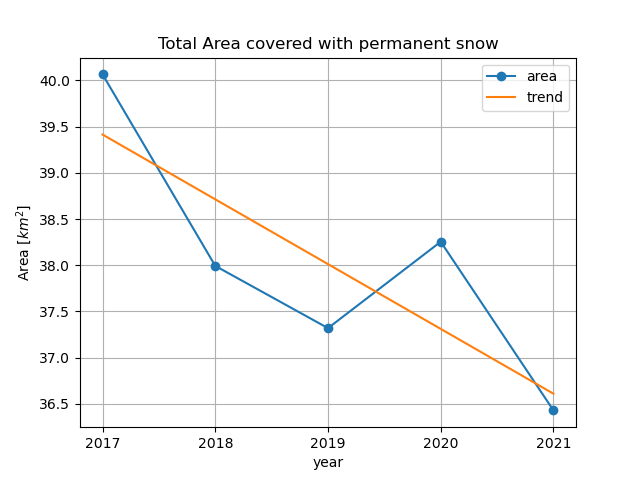

In [15]:
# calculate area for each year
data = pd.DataFrame(columns = ['area'], index = years)
for year in years:
    data.loc[year,'area'] = all_shapes_data[year].area.sum()*1e-6 # calculate and convert from m^2 to Km^2
    
# calculate linear trend 
res = scipy.stats.linregress(y=data['area'].values.astype(float), x=data.index.astype(int))
data[f'trend']= res.intercept + res.slope*data.index.astype(int)

# visualize
ax = data.plot(y = 'area',style = '-o', xticks = data.index)
ax = data.plot(ax=ax, y = 'trend', style = '-', xticks = data.index)
ax.set_ylabel('Area [$km^2$]')
ax.set_xlabel('year')
ax.grid()
tt = ax.set_title('Total Area covered with permanent snow')

<div class="alert alert-block alert-warning">

### Challenge:

This last plot is clearly representative of the situations in many other glaciers in Europe adn Around the world. Satellite data are key to carry out these types of analysis even at larger scale, so here's some more interesting application for you to try out:
   * Changethe Region of Interest (Bounding Box) to an another famous glacier and perform the same analysis, or to a broader region (the entire Alps?) to have a full overview.
   * Compare these data with other important dataset related with Glaciers that are featured in teh WEkEO webiste: 
        
    1.- Glaciers distribution data from the Randolph Glacier Inventory for year 2000 (EO:ECMWF:DAT:GLACIERS_DISTRIBUTION_DATA_FROM_RANDOLPH_GLACIER_INVENTORY_2000)
    
    2.- Glaciers elevation and mass change data from 1850 to present from the Fluctuations of Glaciers Database (EO:ECMWF:DAT:GLACIERS_ELEVATION_AND_MASS_CHANGE_DATA_1850_PRESENT)
 <div>